In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from utils import PCP, train_val_test_split

In [2]:
alpha = 0.1
seed = 2023
np.random.seed(seed)
dataset_base_path = "datasets/"
dataset_name = "community"
X, Y = datasets.GetDataset(dataset_name, dataset_base_path)

In [3]:
attrib = pd.read_csv(dataset_base_path + 'communities_attributes.csv', delim_whitespace = True)
data = pd.read_csv(dataset_base_path + 'communities.data', names = attrib['attributes'])
crimedata = pd.read_csv(dataset_base_path + "crimedata.csv",sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})

to_num_2 = {'AL': 1, 'AK': 2,  'AZ': 4, 'AR': 5, 'CA': 6, 'CO': 8, 'CT': 9, 'DE': 10, 'DC': 11, 'FL': 12, 'GA': 13, 'IL': 14, 'ID': 16, 'IN': 18, 'IA': 19,  
          'KS': 20, 'KY': 21,  'LA': 22, 'ME': 23, 'MD': 24, 'MA': 25, 'MI':26,  'MN': 27,  'MS': 28, 
          'MO': 29, 'NV': 32,  'NH': 33, 'NJ': 34, 'NM': 35, 'NY': 36, 'NC': 37, 'ND': 38,
          'OH': 39, 'OK': 40, 'OR': 41, 'PA': 42, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47,  
          'TX': 48, 'UT': 49, 'VT': 50, 
          'VA': 51, 'WA': 53, 'WV': 54, 'WI': 55, 'WY': 56
    
}

state_map = crimedata['state'].map(to_num_2)
state_map = np.array(state_map)

match_list = []
for j in range(data.shape[0]):
    
    a = crimedata['communityName']==data.iloc[j]['communityname']
    b = np.array(state_map) == data.iloc[j]['state']
    match_list.append(np.where(a*b==1)[0][0])

unormalized_data = crimedata.iloc[match_list]

In [4]:
data = data.drop(columns=['state','county',
                          'community','communityname',
                          'fold'], axis=1)
        
data = data.replace('?', np.nan)

# Impute mean values for samples with missing values        
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])
data = data.dropna(axis=1)


In [5]:
unormalized_data = unormalized_data[unormalized_data.columns.intersection(data.columns)]

unormalized_data = unormalized_data.replace('?', np.nan)

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer = imputer.fit(unormalized_data[['OtherPerCap']])
unormalized_data[['OtherPerCap']] = imputer.transform(unormalized_data[['OtherPerCap']])
unormalized_data = unormalized_data.dropna(axis=1)

In [7]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, X_test_0, idx_test = train_val_test_split(X,Y,1/3,return_index=True)
RF =  RandomForestRegressor().fit(X_train,Y_train)
R_val = abs(Y_val - RF.predict(X_val))
R_test = abs(Y_test - RF.predict(X_test))

kf = KFold(n_splits=20, shuffle=True)
R_train = np.zeros_like(Y_train)
for train_index, test_index in kf.split(X_train):

    RF_train =  RandomForestRegressor().fit(X_train[train_index],Y_train[train_index])
    R_train[test_index] = abs(Y_train[test_index] - RF_train.predict(X_train[test_index]))

In [8]:
PCP_model = PCP()
PCP_model.train(X_train,R_train,info=True)

r_square: 0.9459729684452112
number of components: 3
sample size m: 76


In [9]:
q_pcp, coverage_pcp, pi_list = PCP_model.calibrate(X_val, R_val,X_test, R_test, alpha,return_pi= True)

666it [01:44,  6.35it/s]
666it [00:55, 11.92it/s]


In [11]:
feature =12
data_test = unormalized_data[data.columns[feature]].iloc[idx_test]
indices = np.argsort(X_test[:,feature])#(data_test)
V_test = data_test.iloc[indices]
x_grid = np.linspace(min(data_test), max(data_test),1000)

pi = np.array(pi_list)
q_pcp = np.array(q_pcp)
pred = RF.predict(X_test)
N, K = np.shape(pi_list)

my_dict = {}
for k in range(K):
    my_dict[str(k)] = []
    for x in x_grid:
        idx = np.array(abs(x - data_test )**2).argsort()[:100]
        my_dict[str(k)].append(np.mean(pi[idx,k]))

my_dict['q'] = []
for x in x_grid:
    idx = np.array(abs(x - data_test )).argsort()[:100]
    q = q_pcp[idx]
    my_dict['q'].append(np.mean(q[q!=np.inf]))

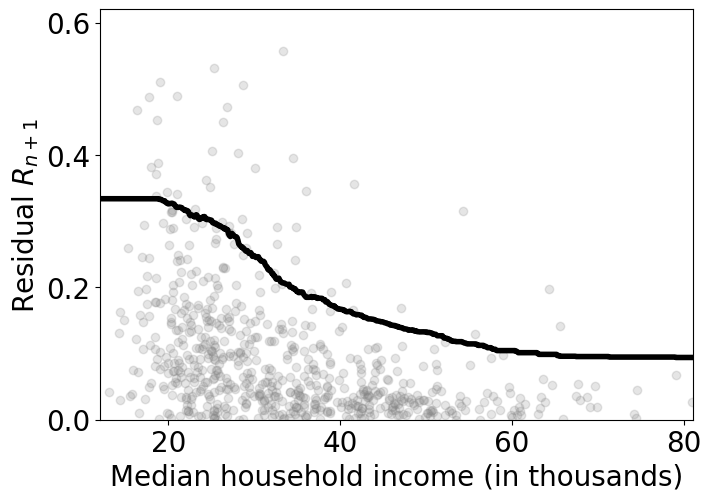

In [12]:
import seaborn as sns
set2_colors = sns.color_palette("Set2")
fig, ax = plt.subplots(layout='constrained', figsize=(7,4.9))

ax.scatter(data_test/1000, R_test, alpha=0.2,color = "tab:grey")
ax.plot(x_grid/1000,  my_dict['q'],linewidth=4,color = "black")
ax.set_xlabel("Median household income (in thousands)", fontsize=20)
ax.set_ylabel("Residual $R_{n+1}$",fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlim(12.1,81)
ax.set_xticks([20,40,60,80])
ax.set_yticks([0,0.2,0.4,0.6])
ax.set_ylim(0,0.62)

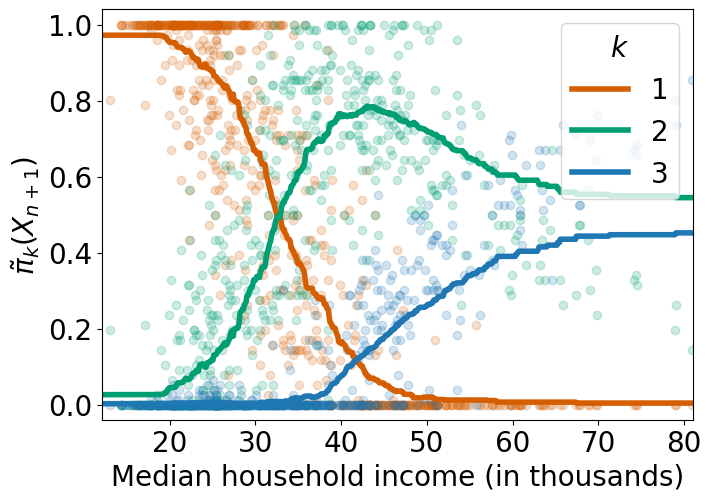

In [14]:
import seaborn as sns
set2_colors = sns.color_palette("Set2")
fig, ax = plt.subplots(layout='constrained',figsize=(7,4.9))

ax.scatter(data_test/1000, pi[:,1],color = "#D55E00",alpha=0.2)
ax.scatter(data_test/1000, pi[:,0],color = "#009E73",alpha=0.2)
ax.scatter(data_test/1000, pi[:,2],color = "tab:blue",alpha=0.2)
ax.plot(x_grid/1000, my_dict[str(1)], linewidth=4,color = "#D55E00",label = '$1$')
ax.plot(x_grid/1000, my_dict[str(0)], linewidth=4,color = "#009E73",label = '$2$')
ax.plot(x_grid/1000, my_dict[str(2)], linewidth=4,color = "tab:blue",label = '$3$')
#ax.plot(V_test, my_dict[str(3)], linewidth=4,color = set2_colors[4])
ax.set_ylabel(r'$\tilde{\pi}_k(X_{n+1})$',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("Median household income (in thousands)", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
legend = ax.legend(title="$k$", loc='upper right', fontsize=20) #,  
plt.setp(legend.get_title(), fontsize=20)
ax.set_ylim(-0.04,1.04)
ax.set_xlim(12.1,81)

ViolentCrimesPerPop


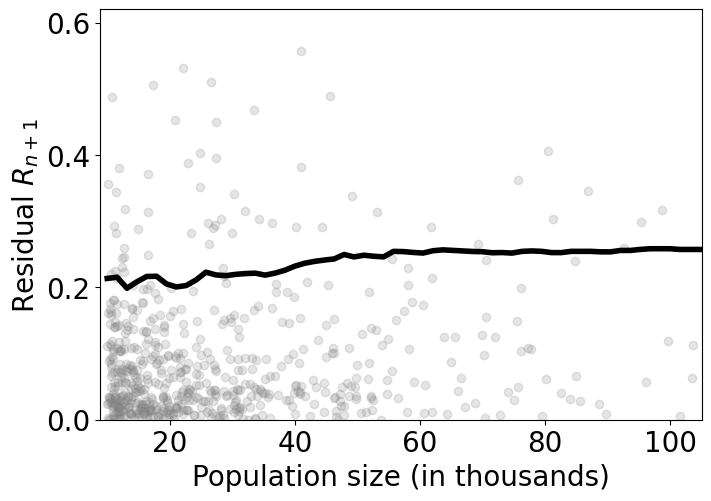

In [15]:
feature = 0
data_test = unormalized_data[data.columns[feature]].iloc[idx_test]
indices = np.argsort(X_test[:,feature])#(data_test)
V_test = data_test.iloc[indices]
x_grid = np.linspace(min(data_test), max(data_test),1000)

pi = np.array(pi_list)
q_pcp = np.array(q_pcp)
N, K = np.shape(pi_list)

my_dict = {}
for k in range(K):
    my_dict[str(k)] = []
    for x in x_grid:
        idx = np.array(abs(x - data_test )**2).argsort()[:100]
        my_dict[str(k)].append(np.mean(pi[idx,k]))

my_dict['q'] = []
for x in x_grid:
    idx = np.array(abs(x - data_test )).argsort()[:100]
    q = q_pcp[idx]
    my_dict['q'].append(np.mean(q[q!=np.inf]))

print(data.columns[feature-1])
import seaborn as sns
set2_colors = sns.color_palette("Set2")
fig, ax = plt.subplots(layout='constrained', figsize=(7,4.9))

ax.scatter(data_test/1000, R_test, alpha=0.2,color = "tab:grey")
ax.plot(x_grid/1000,  my_dict['q'],linewidth=4, color = "black")
ax.set_xlabel("Population size (in thousands)", fontsize=20)
ax.set_ylabel("Residual $R_{n+1}$",fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_yticks([0,0.2,0.4,0.6])
ax.set_ylim(0,0.62)
ax.set_xlim(8.9,105)

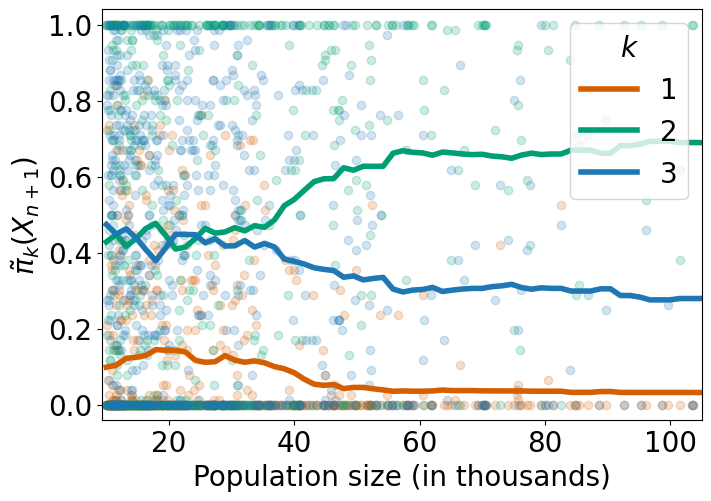

In [16]:
import seaborn as sns
set2_colors = sns.color_palette("Set2")
fig, ax = plt.subplots(layout='constrained',figsize=(7,4.9))

ax.scatter(data_test/1000, pi[:,2],color = "#D55E00",alpha=0.2)
ax.scatter(data_test/1000, pi[:,1],color = "#009E73",alpha=0.2)
ax.scatter(data_test/1000, pi[:,0],color = "tab:blue",alpha=0.2)
ax.plot(x_grid/1000, my_dict[str(2)], linewidth=4,color = "#D55E00",label = '$1$')
ax.plot(x_grid/1000, my_dict[str(1)], linewidth=4,color = "#009E73",label = '$2$')
ax.plot(x_grid/1000, my_dict[str(0)], linewidth=4,color = "tab:blue",label = '$3$')
ax.set_ylabel(r'$\tilde{\pi}_k(X_{n+1})$', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("Population size (in thousands)",  fontsize=20)
ax.tick_params(axis='y', labelsize=20)
legend = ax.legend(title="$k$", fontsize=20)
plt.setp(legend.get_title(), fontsize=20)
ax.set_ylim(-0.04,1.04)
ax.set_xlim(9.3,105)